# RL homework 3

-------------------------------


**Name:** Alexandra Maria Proca

**SN:** 20047328

-----------------------------------


**Due date:** *10th May, 2021, 4:00 pm*

------------------------------------

## How to Submit

When you have completed the exercises and everything has finsihed running, click on 'File' in the menu-bar and then 'Download .ipynb'. This file must be submitted to Moodle named as **studentnumber_RL_hw3.ipynb** before the deadline above.

# The Assignment

### Objectives

#### Part 1:
You will implement several algorithms to investigate the role of planning in reinforcement learning.

#### Part 2:
You will be guided through the implementation of a full deep reinforcement learning agent.

#### Part 3:
You will implement a number of off-policy multi-step return estimates, and answer questions about their accuracy.



# Setup

Run all the cells in this section, but do not modify them.

## Imports

In [62]:
import functools
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple

np.set_printoptions(precision=3, suppress=1)
plt.style.use('seaborn-notebook')

## Gridworlds

In [63]:
#@title Implementation
class Grid(object):

  def __init__(self, discount=0.9):
    # -1: wall
    # 0: empty, episode continues
    # other: number indicates reward, episode will terminate
    self._layout = np.array([
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0, -1, -1,  0,  0, 10, -1],
      [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
      [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
    ])
    self._start_state = (2, 2)
    self._goal_state = (8, 2)
    self._state = self._start_state
    self._number_of_states = np.prod(np.shape(self._layout))
    self._discount = discount

  @property
  def number_of_states(self):
      return self._number_of_states
    
  def plot_grid(self):
    plt.figure(figsize=(3, 3))
    plt.imshow(self._layout > -1, interpolation="nearest", cmap="YlOrRd_r")     
    ax = plt.gca()
    ax.grid(0)
    plt.xticks([])
    plt.yticks([])
    plt.title("The grid")
    plt.text(
        self._start_state[0], self._start_state[1], 
        r"$\mathbf{S}$", ha='center', va='center')
    plt.text(
        self._goal_state[0], self._goal_state[1], 
        r"$\mathbf{G}$", ha='center', va='center')
    h, w = self._layout.shape
    for y in range(h-3):
      plt.plot([+0.5, w-1.5], [y+1.5, y+1.5], '-k', lw=2, alpha=0.5)
    for x in range(w-3):
      plt.plot([x+1.5, x+1.5], [+0.5, h-1.5], '-k', lw=2, alpha=0.5)

  
  def get_obs(self):
    y, x = self._state
    return y*self._layout.shape[1] + x
  
  def int_to_state(self, int_obs):
    x = int_obs % self._layout.shape[1]
    y = int_obs // self._layout.shape[1]
    return y, x

  def step(self, action):
    y, x = self._state

    if action == 0:  # up
      new_state = (y - 1, x)
    elif action == 1:  # right
      new_state = (y, x + 1)
    elif action == 2:  # down
      new_state = (y + 1, x)
    elif action == 3:  # left
      new_state = (y, x - 1)
    else:
      raise ValueError("Invalid action: {} is not 0, 1, 2, or 3.".format(action))

    new_y, new_x = new_state
    if self._layout[new_y, new_x] == -1:  # wall
      reward = -5.
      discount = self._discount
      new_state = (y, x)
    elif self._layout[new_y, new_x] == 0:  # empty cell
      reward = 0.
      discount = self._discount
    else:  # a goal
      reward = self._layout[new_y, new_x]
      discount = 0.
      new_state = self._start_state
    
    self._state = new_state
    return reward, discount, self.get_obs()
  
class AltGrid(Grid):
  
    def __init__(self, discount=0.9):
      # -1: wall
      # 0: empty, episode continues
      # other: number indicates reward, episode will terminate
      self._layout = np.array([
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
        [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
        [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
        [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
        [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
        [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
        [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
        [-1,  0, 10,  0,  0,  0,  0,  0,  0, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
      ])
      self._start_state = (2, 2)
      self._goal_state = (2, 7)
      self._state = self._start_state
      self._number_of_states = np.prod(np.shape(self._layout))
      self._discount = discount

class FeatureGrid(Grid):
  
  def get_obs(self):
    return self.state_to_features(self._state)
  
  def state_to_features(self, state):
    y, x = state
    x /= float(self._layout.shape[1] - 1)
    y /= float(self._layout.shape[0] - 1)
    markers = np.arange(0.1, 1.0, 0.1)
    features = np.array([np.exp(-40*((x - m)**2+(y - n)**2))
                         for m in markers
                         for n in markers] + [1.])
    return features / np.sum(features**2)
  
  def int_to_features(self, int_state):
    return self.state_to_features(self.int_to_state(int_state))
  
  @property
  def number_of_features(self):
      return len(self.get_obs())

A grid world


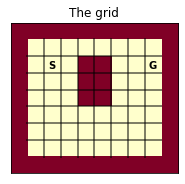


An alternative grid world


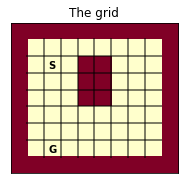


Features (visualised as 9x9 heatmaps) for different locations in the grid
(Note: includes unreachable states that coincide with walls in this visualisation.)


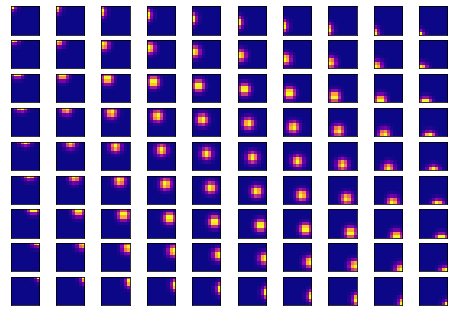

In [111]:
#@title Show gridworlds

# Plot tabular environments
grid = Grid()
alt_grid = AltGrid()
print("A grid world")
grid.plot_grid()
plt.show()
print("\nAn alternative grid world")
alt_grid.plot_grid()
plt.show()

# Plot features of each state for non tabular version of the environment.
print(
    "\nFeatures (visualised as 9x9 heatmaps) for different locations in the grid"
    "\n(Note: includes unreachable states that coincide with walls in this visualisation.)"
)
feat_grid = FeatureGrid()
shape = feat_grid._layout.shape
f, axes = plt.subplots(shape[0], shape[1])
for state_idx, ax in enumerate(axes.flatten()):
  ax.imshow(np.reshape((feat_grid.int_to_features(state_idx)[:-1]),(9,9)),
            interpolation='nearest',
            cmap='plasma')
  ax.set_xticks([])
  ax.set_yticks([])
plt.show()

## Helpers

In [64]:
#@title helper functions (run, but don't modify this cell)

def run_experiment(env, agent, number_of_steps):
    mean_reward = 0.
    try:
      action = agent.initial_action()
    except AttributeError:
      action = 0
    for i in range(number_of_steps):
      reward, discount, next_state = env.step(action)
      action = agent.step(reward, discount, next_state)
      mean_reward += (reward - mean_reward)/(i + 1.)

    return mean_reward
  
map_from_action_to_subplot = lambda a: (2, 6, 8, 4)[a]
map_from_action_to_name = lambda a: ("up", "right", "down", "left")[a]

def plot_rewards(xs, rewards, color):
  mean = np.mean(rewards, axis=0)
  p90 = np.percentile(rewards, 90, axis=0)
  p10 = np.percentile(rewards, 10, axis=0)
  plt.plot(xs, mean, color=color, alpha=0.6)
  plt.fill_between(xs, p90, p10, color=color, alpha=0.3)

def plot_values(values, colormap='pink', vmin=-1, vmax=10):
  plt.imshow(values, interpolation="nearest", cmap=colormap, vmin=vmin, vmax=vmax)
  plt.yticks([])
  plt.xticks([])
  plt.colorbar(ticks=[vmin, vmax])

def plot_state_value(action_values):
  q = action_values
  fig = plt.figure(figsize=(4, 4))
  vmin = np.min(action_values)
  vmax = np.max(action_values)
  v = 0.9 * np.max(q, axis=-1) + 0.1 * np.mean(q, axis=-1)
  plot_values(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")

def plot_action_values(action_values):
  q = action_values
  fig = plt.figure(figsize=(8, 8))
  fig.subplots_adjust(wspace=0.3, hspace=0.3)
  vmin = np.min(action_values)
  vmax = np.max(action_values)
  dif = vmax - vmin
  for a in [0, 1, 2, 3]:
    plt.subplot(3, 3, map_from_action_to_subplot(a))
    
    plot_values(q[..., a], vmin=vmin - 0.05*dif, vmax=vmax + 0.05*dif)
    action_name = map_from_action_to_name(a)
    plt.title(r"$q(s, \mathrm{" + action_name + r"})$")
    
  plt.subplot(3, 3, 5)
  v = 0.9 * np.max(q, axis=-1) + 0.1 * np.mean(q, axis=-1)
  plot_values(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")

def parameter_study(parameter_values, parameter_name,
  agent_constructor, env_constructor, color, repetitions=10, number_of_steps=int(1e4)):
  mean_rewards = np.zeros((repetitions, len(parameter_values)))
  greedy_rewards = np.zeros((repetitions, len(parameter_values)))
  for rep in range(repetitions):
    for i, p in enumerate(parameter_values):
      env = env_constructor()
      agent = agent_constructor()
      if 'eps' in parameter_name:
        agent.set_epsilon(p)
      elif 'alpha' in parameter_name:
        agent._step_size = p
      else:
        raise NameError("Unknown parameter_name: {}".format(parameter_name))
      mean_rewards[rep, i] = run_experiment(grid, agent, number_of_steps)
      agent.set_epsilon(0.)
      agent._step_size = 0.
      greedy_rewards[rep, i] = run_experiment(grid, agent, number_of_steps//10)
      del env
      del agent

  plt.subplot(1, 2, 1)
  plot_rewards(parameter_values, mean_rewards, color)
  plt.yticks=([0, 1], [0, 1])
  plt.ylabel("Average reward over first {} steps".format(number_of_steps), size=12)
  plt.xlabel(parameter_name, size=12)

  plt.subplot(1, 2, 2)
  plot_rewards(parameter_values, greedy_rewards, color)
  plt.yticks=([0, 1], [0, 1])
  plt.ylabel("Final rewards, with greedy policy".format(number_of_steps), size=12)
  plt.xlabel(parameter_name, size=12)
  
def random_policy(q):
  return np.random.randint(4)

def epsilon_greedy(q_values, epsilon):
  if epsilon < np.random.random():
    return np.argmax(q_values)
  else:
    return np.random.randint(np.array(q_values).shape[-1])

def plot_greedy_policy(grid, q):
  action_names = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"]
  greedy_actions = np.argmax(q, axis=2)
  grid.plot_grid()
  for i in range(9):
    for j in range(10):
      action_name = action_names[greedy_actions[i,j]]
      plt.text(j, i, action_name, ha='center', va='center')

def plot_greedy_policy_v2(grid, pi):
  action_names = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"]
  greedy_actions = np.argmax(pi, axis=2)
  grid.plot_grid()
  h, w = grid._layout.shape
  for y in range(2, h-2):
    for x in range(2, w-2):
      action_name = action_names[greedy_actions[y-2, x-2]]
      plt.text(x, y, action_name, ha='center', va='center')

# Part 1: Planning [35 marks]

## 1.1: Implement Models

### Q 1.1.1 [3 marks]

Implement a trainable **tabular model** of the environment.

The model should implement: 
* a *next_state* method, taking a state and action and returning the next state in the environment.
* a *reward* method, taking a state and action and returning the immediate reward associated to executing that action in that state.
* a *discount* method, taking a state and action and returning the discount associated to executing that action in that state.
* a *transition* method, taking a state and an action and returning both the next state and the reward associated to that transition.
* a *update* method, taking a full transition *(state, action, reward, next_state)* and updating the model predictions.

Given that the environment is deterministic and tabular the model will reduce to a simple lookup table.

In [65]:
class TabularModel(object):

  def __init__(self, number_of_states, number_of_actions):
    self.states = np.zeros((number_of_states, number_of_actions))
    self.rewards = np.zeros((number_of_states, number_of_actions))
    self.discounts = np.zeros((number_of_states, number_of_actions))
    self.t = np.zeros((number_of_states, number_of_actions))

  def next_state(self, s, a):
    return self.states[s, a]
  
  def reward(self, s, a):
    return self.rewards[s, a]

  def discount(self, s, a):
    return self.discounts[s, a]
  
  def transition(self, state, action):
    return (
        self.reward(state, action), 
        self.discount(state, action),
        self.next_state(state, action))
  
  def update(self, state, action, reward, discount, next_state): 
    self.t[state, action] += 1
    self.states[state, action] = next_state
    self.rewards[state, action] = reward 
    self.discounts[state, action] = discount 

### Q 1.1.2 [3 marks]

Implement a trainable **linear model** of the environment.

The Model should implement: 
* a *next_state* method, taking a state and action and returning the predicted next state in the environment.
* a *reward* method, taking a state and action and returning the predicted immediate reward associated to executing that action in that state.
* a *discount* method, taking a state and action and returning the predicted discount associated to executing that action in that state.
* a *transition* method, taking a state and an action and returning both the next state and the reward associated to that transition.
* a *update* method, taking a full transition *(state, action, reward, next_state)* and updating the model (in its reward, discount and next_state component)

For each selected action, the predicted reward $r'$, discount $\gamma'$ and next state $\mathbf{s}'$ will all be a linear function of the current state $\mathbf{s}$.
* $\mathbf{s}' = \mathbf{M}_a \mathbf{s}$
* $r' = (\mathbf{m}^r_a)^{\top} \mathbf{s}$
* $\gamma' = (\mathbf{m}^{\gamma}_a)^{\top} \mathbf{s}$

Where $\mathbf{M}_a$ is a matrix of shape $(\text{number_of_features}, \text{number_of_features})$, $\mathbf{m}^r_a$ and $\mathbf{m}^{\gamma}_a$ are vectors of shape $(\text{number_of_features},)$

The parameters of all these linear transformations must be trained by stochastic gradient descent. 

Write down the update to the parameters of the models and implement the update in the model below.


In [66]:
class LinearModel(object):

  def __init__(self, number_of_features, number_of_actions):
    self.M = np.zeros((number_of_actions, number_of_features, number_of_features))
    self.m_r = np.zeros((number_of_actions, number_of_features)) 
    self.m_gamma = np.zeros((number_of_actions, number_of_features))

  def next_state(self, s, a):
    return self.M[a] @ s
  
  def reward(self, s, a):
    return self.m_r[a] @ s

  def discount(self, s, a):
    return self.m_gamma[a] @ s

  def transition(self, state, action):
    return (
        self.reward(state, action),
        self.discount(state, action),
        self.next_state(state, action))

  def update(self, state, action, reward, discount, next_state, step_size=0.1):
    self.M[action] += step_size*((next_state - self.next_state(state, action)).reshape(-1,1) @ state.reshape(1,-1))
    self.m_r[action] += step_size*(reward - self.reward(state, action)) * state
    self.m_gamma[action] += step_size*(discount - self.discount(state, action)) * state

## 1.2: Implement Agents

We are going to implement 4 agent:
- Tabular Q-learning with Experience Replay
- Tabular Dyna-Q with a tabular model
- Linear Q-learning with Experience Replay
- Linear Dyna-Q with a linear model

All agents you implement in this section must share the agent interface below:

#### `__init__(self, number_of_actions, number_of_states, initial_observation)`:
The constructor will provide the agent the number of actions, number of states, and the initial observation. You can get such initial observation by instatiating an environment (e.g., `grid = Grid()`), and then calling `grid.get_obs()`.

#### `step(self, reward, discount, next_observation)`:
The step should update the internal values, and return a new action to take. When the discount is zero ($\text{discount} = \gamma = 0$), the `next_observation` will be the initial observation of the next episode.  One shouldn't bootstrap on the value of this state, which can simply be guaranteed when using "$\gamma \cdot v(\text{next_observation})$" in the update, because $\gamma = 0$.  So, the end of an episode can be seamlessly handled with the same step function. Note that to perform updates within the `step` function you typically need to store the previous state and/or action: you may set such previous action to 0 in the constructor for consumption in the first step of the first episode of the agent's lifetime.
 
#### `q_values()`:
For tabular agents **only**. This method must return a matrix of Q values of shape: (`number_of_states`, `number_of_actions`)

#### `q_values(state)`:
For agents with function approximation **only**. This method must return an array of Q values of shape: (`number_of_actions`)


### Q 1.2.1 [3 marks]

Implement an agent that uses **Experience Replay** to learn action values, at each step:
* select actions randomly
* accumulate each observed transition *(s, a, r, g, s')* in a *replay buffer*,
* apply an online Q-learning update with the most recently observed transition,
* apply multiple Q-learning updates based on transitions sampled (uniformly) from the *replay buffer* (in addition to the online updates).

So, the `step` function of the agent will, conceptually, look as follows:

1. Append most recent observed transition $(S_t, A_t, R_{t+1}, \gamma, S_{t+1})$ to replay buffer

1. Update values: $Q(S_t, A_t)$ with Q-learning, using transition $(S_t, A_t, R_{t+1}, \gamma, S_{t+1})$ 

1. Loop repeat n times:

  1. Sample $S, A, R, \gamma, S'$ from replay
  
  1. Update values: $Q(S, A)$ with Q-learning, using transition $(S, A, R, \gamma, S')$ 

In [67]:
 class ExperienceQ(object):

  def __init__(
      self, number_of_states, number_of_actions, initial_state, 
      behaviour_policy, num_offline_updates=0, step_size=0.1):
    self.Q = np.zeros((number_of_states, number_of_actions))
    self._state = initial_state
    self._action = 0
    self.behavior_policy = behaviour_policy
    self.num_offline_updates = num_offline_updates
    self.step_size = step_size
    self.buffer = []
    
  @property
  def q_values(self):
    return self.Q

  def step(self, reward, discount, next_state):
    s = self._state
    a = self._action
    r = reward
    g = discount
    next_s = next_state
    self.buffer.append((s, a, r, g, next_s))
    self.Q[s, a] += self.step_size*(r + g*np.max(self.Q[next_s]) - self.Q[s,a])
    ind = np.random.randint(0, len(self.buffer), self.num_offline_updates)
    for i in range(0, self.num_offline_updates):
        samp = self.buffer[ind[i]]
        self.Q[samp[0], samp[1]] += self.step_size*(samp[2] + samp[3]*np.max(self.Q[samp[4]]) - self.Q[samp[0],samp[1]])    
    self._state = next_s
    self._action = self.behavior_policy(self.Q[next_s])
    return self._action


### Q 1.2.2 [3 marks]

Implement an agent that uses **Dyna-Q** to learn action values.
* select actions randomly
* accumulate all observed transitions *(s, a)* in the environment in a *replay buffer*,
* apply an online Q-learning to Q-value
* apply an update to the *model* based on the latest transition
* apply multiple Q-learning updates based on transitions *(s, a, model.reward(s), model.next_state(s))* for some previous state and action pair *(s, a)*.

So, the `step` function conceptually looks as follows:
1. Append most recent observed transition $(S_t, A_t)$ to replay buffer

1. Update values: $Q(S_t, A_t)$ with Q-learning, using transition $(S_t, A_t, R_{t+1}, \gamma, S_{t+1})$

1. Update model: $M(S_t, A_t)$, using transition $(S_t, A_t, R_{t+1}, \gamma, S_{t+1})$

1. Loop repeat n times:

  1. Sample $S, A$ from replay
  
  1. Generate $R, \gamma, S' = M(S, A)$
  
  1. Update values: $Q(S, A)$ with Q-learning, using transition $(S, A, R, \gamma, S')$ 

In [68]:
class DynaQ(object):

  def __init__(
      self, number_of_states, number_of_actions, initial_state, 
      behaviour_policy, num_offline_updates=0, step_size=0.1):
    self.Q = np.zeros((number_of_states, number_of_actions))
    self.M = TabularModel(number_of_states, number_of_actions)
    self._state = initial_state
    self._action = 0 
    self.behavior_policy = behaviour_policy
    self.num_offline_updates = num_offline_updates
    self.step_size = step_size
    self.buffer = []
    
  @property
  def q_values(self):
    return self.Q

  def step(self, reward, discount, next_state):
    s = self._state
    a = self._action
    r = reward
    g = discount
    next_s = next_state
    self.buffer.append((s, a))
    self.Q[s, a] += self.step_size*(r + g*np.max(self.Q[next_s]) - self.Q[s, a])
    self.M.update(s, a, r, g, next_s)
    ind = np.random.randint(0, len(self.buffer), self.num_offline_updates)
    for i in range(0, self.num_offline_updates):
        samp = self.buffer[ind[i]]
        s_r, s_g, s_next_s = self.M.transition(samp[0], samp[1])
        self.Q[samp[0],samp[1]] += self.step_size*(s_r + s_g*np.max(self.Q[int(s_next_s)]) - self.Q[samp[0],samp[1]])    
    self._state = next_s
    self._action = self.behavior_policy(self.Q[next_s])
    return self._action

### Q 1.2.3 [2 marks]

Implement an agent that uses **Experience Replay** to learn action values as a **linear function approximation** over a given set of features.

Learn the value estimates via online stochastic gradient descent.  The observed `state` will now be a vector of length `number_of_features`, and the value estimate will be $w_t^\top x_t$, where $w_t$ are the current weights and $x_t$ is the observed (agent) state at time $t$.

In [69]:
class LinearExperienceQ(ExperienceQ):

  def __init__(
      self, number_of_features, number_of_actions, *args, **kwargs):
    super(LinearExperienceQ, self).__init__(
        number_of_actions=number_of_actions, *args, **kwargs)
    self.W = np.zeros((number_of_actions, number_of_features))

  def q(self, state):
    return self.W @ state

  def step(self, reward, discount, next_state):
    s = self._state
    a = self._action
    r = reward
    g = discount
    next_s = next_state
    self.buffer.append((s, a, r, g, next_s))
    self.W[a] += self.step_size*(r + g*np.max(self.q(next_s)) - self.q(s)[a])*s    
    ind = np.random.randint(0, len(self.buffer), self.num_offline_updates)
    for i in range(0, self.num_offline_updates):
        samp = self.buffer[ind[i]]
        self.W[samp[1]] += self.step_size*(samp[2] + samp[3]*np.max(self.q(samp[4])) - self.q(samp[0])[samp[1]])*samp[0]    
    self._state = next_s
    self._action = self.behavior_policy(self.q(next_s))
    return self._action

### Q 1.2.4 [3 marks]

Implement an agent that uses **Dyna-Q** that uses a **linear function approximation** to represent values as well as for the model of the environment.

Represent and learn both the **transition model** and the **reward model** as linear, action-dependent transformations of the given set of features.  The transition and reward models should be represented separately.  Implement separate models for each action (instead of, e.g., passing a one-hot identifier of the action in).

Learn value estimates, transition model and reward model via online stochastic gradient descent.

In [81]:
class LinearDynaQ(DynaQ):

  def __init__(self, number_of_features, number_of_actions, model_step_size=0.1,
               *args, **kwargs):
    super(LinearDynaQ, self).__init__(
        number_of_actions=number_of_actions, *args, **kwargs)
    self.W = np.zeros((number_of_actions, number_of_features))
    self.model_step_size = 0.1
    self.M = LinearModel(number_of_features, number_of_actions)

  def q(self, state):
    return self.W @ state

  def step(self, reward, discount, next_state):
    s = self._state
    a = self._action
    r = reward
    g = discount
    next_s = next_state
    self.buffer.append((s, a))
    self.W[a] += self.step_size*(r + g*np.max(self.q(next_s)) - self.q(s)[a])*s 
    self.M.update(s, a, r, g, next_s, self.model_step_size)
    ind = np.random.randint(0, len(self.buffer), self.num_offline_updates)
    for i in range(0, self.num_offline_updates):
        samp = self.buffer[ind[i]]
        s_r, s_g, s_next_s = self.M.transition(samp[0], samp[1])
        self.W[samp[1]] += self.step_size*(s_r + s_g*np.max(self.q(s_next_s)) - self.q(samp[0])[samp[1]])*samp[0]
    self._state = next_s
    self._action = self.behavior_policy(self.q(next_s))
    return self._action

## 1.3: Analyse Results

You will have to analyse experiments that evaluate each of these 5 agents in various settings, and in terms of different metrics.

- Tabular learning: data efficiency
- Tabular learning: computational efficiency
- Linear function approximation
- Learning in non-stationary environments

### Run data efficiency experiments

*Online Q-learning*

* $\text{number_of_steps}$ = $2000$ and $\text{num_offline_updates}$ = $0$

*Experience Replay*

* $\text{number_of_steps}$ = $2000$ and $\text{num_offline_updates}$ = $30$

*DynaQ*

* $\text{number_of_steps}$ = $2000$ and $\text{num_offline_updates}$ = $30$

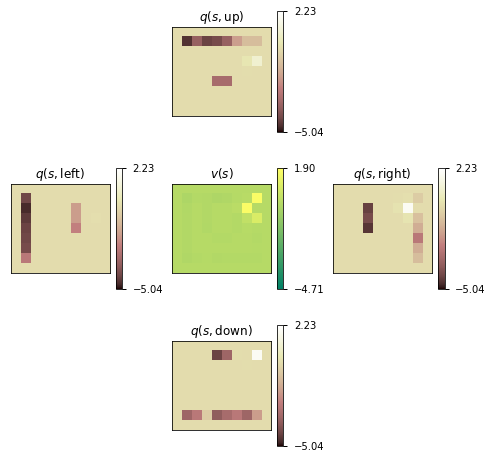

In [119]:
# Online Q
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=0, step_size=0.1)
run_experiment(grid, agent, int(2e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

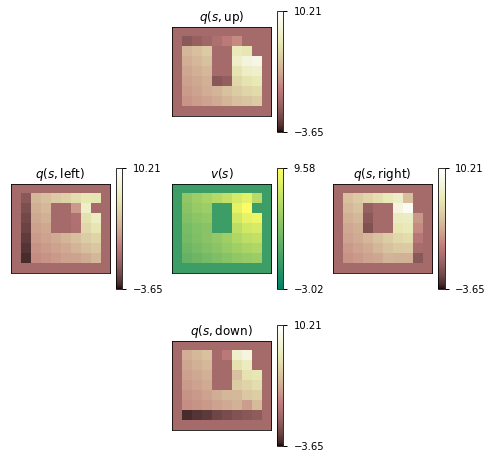

In [120]:
# Experience Replay
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(2e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

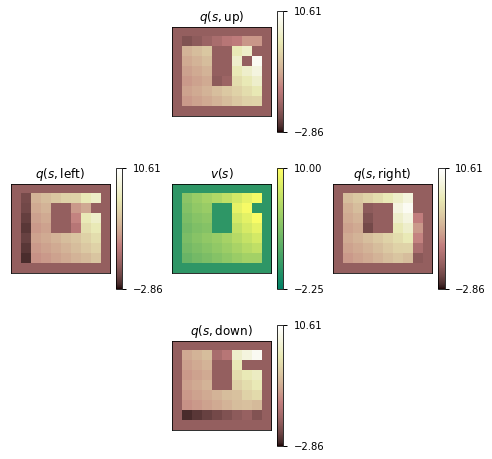

In [134]:
# DynaQ
grid = Grid()
agent = DynaQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(2e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

### Q 1.3.1 [3 marks]

In the experiments above, how do the learnt value estimates differ between the online Q-learning, ExperienceReplay, and Dyna Q agents?

Explain meaningful differences in at most 5 sentences.

> The learnt value estimates are significantly different between the online Q-learning agent and the other two agents: online Q-Learning does not learn action value estimates well, as it only manages to differentiate values at the extreme boundaries of the grid world, but not learn action value estimates for the purpose of reaching the goal. It also has uniform value estimates across the grid except at the goal, indicating it has not converged yet and has not learned its environment. Alternatively, ExperienceReplay and Dyna Q have a gradient of value estimates favoring states closer to the goal and low action-values at boundaries which avoid running into walls. The discrepancy between the online Q-learning agent and the other two agents is due to the fact that online Q-learning can only learn on the steps it takes in the environment (on-policy) and thus has a limited amount of data to learn from, with only 2000 steps given; thus, it does not have sufficient time to converge and its value estimates are not accurate or particularly informative. Alternatively, ExperienceReplay and DynaQ learn value estimates much better with only 2000 steps beccause they perform offline updates, sampling previously encountered transitions to update value estimates additionally from single steps. Thus, ExperienceReplay and DynaQ ultimately perform 31 times more updates to value estimates than online Q-learning (62,000 vs. 2,000 updates) and are therefore given ample time and steps to approach convergence and better learn value estimates. Additionally, ExperienceReplay and DynaQ yield similar results of value estimates. This is sensible, as their updates are essentially in the same in this setting because their online updates are identical and their offline updates sample transitions that are stored in the same way with identical information pertaining to states and actions, due to the deterministic environment. Although DynaQ operates through a model with specified values for state-action pair, because the environment only has one output for a state-action pair, sampling from the model yields the same result as sampling from the ExperienceReplay buffer for a particular state-action pair.

### Run experiments matching computational cost

*Online Q-learning*

* $\text{number_of_steps}$ = $62,000$ and $\text{num_offline_updates}$ = $0$

*ExperienceReplay*

* $\text{number_of_steps}$ = $2000$ and $\text{num_offline_updates}$ = $30$

*DynaQ*

* $\text{number_of_steps}$ = $2000$ and $\text{num_offline_updates}$ = $30$

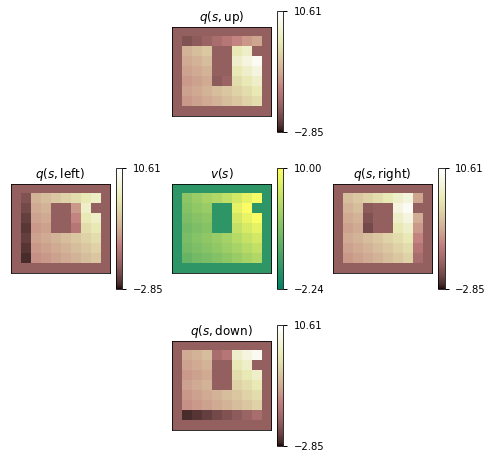

In [122]:
# OnlineQ
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=0, step_size=0.1)
run_experiment(grid, agent, int(62e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

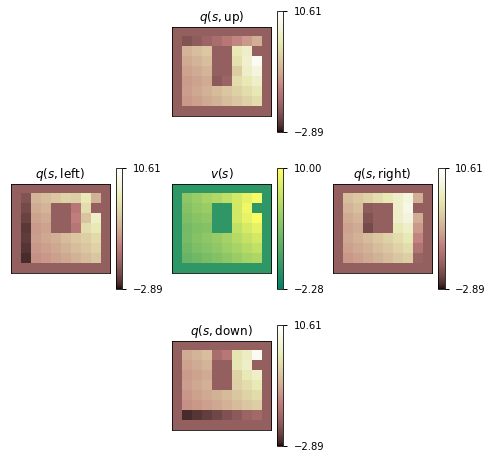

In [123]:
# Experience Replay
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(2e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

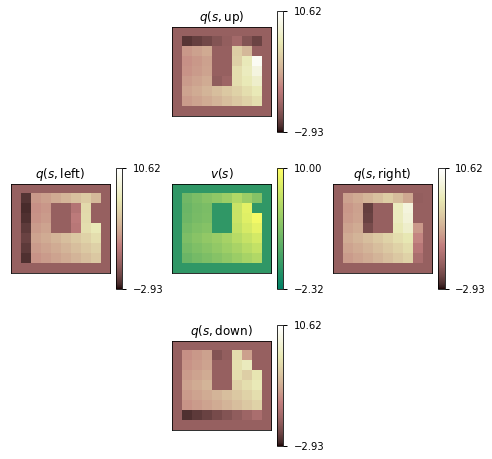

In [135]:
# DynaQ
grid = Grid()
agent = DynaQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(2e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

What if sampling from the environment is cheap and we don't care about data efficiency but only care about the amount of computation we use? 

The experiments directly above are the same as those above question 1.3.1, except that we ran the experiments for the same number of **total updates**, rather than the same number of **steps in the environment**, therefore using more data for the online Q-learning algorithm which *only* updates from real data.

Q 1.3.2 [3 marks]

How do the learnt values, and the relative performances, change, compared to the experiment above question 1.3.1?  Explain in at most 5 sentences.

> The learnt values and relative performance change for online Q-learning such that it appears to learn the same values and perform essentially the same as the other 2 models. This is due to the fact that online Q-learning uses the same number of total updates rather than the same number of steps in the environment as the other algorithms, giving it ample data to learn from and converge to more accurate value estimates. In general, online Q-learning should perform better than ExperienceReplay and DynaQ in a similar setting because it can sample randomly from an unconstrained environment, while ExperienceReplay and DynaQ learn from the constraint of what transitions they have experienced- online Q-learning learns from 62,000 samples from the environment, ExperienceReplay/DynaQ learn from 2,000 samples from the environment (used again approximately 30 times). However, in this particular instance, the grid world is small enough and yields deterministic outputs for each state-action pair such that 2,000 samples are likely to contain all possible state-action pairs multiple times. Thus, it does not make a significant difference in performance to sample from a buffer of observed transitions and from the environment itself, hence why the value estimates are similar across all three models.

### Run experiments with linear function approximation

We will now use the $\text{FeatureGrid}$ domain, and consider the same 3 algorithms in the context of linear function approximation.

*Online Q-learning*

* $\text{number_of_steps}$ = $100,000$ and $\text{num_offline_updates}$ = $0$

*ExperienceReplay*

* $\text{number_of_steps}$ = $100,000$ and $\text{num_offline_updates}$ = $10$

*DynaQ*

* $\text{number_of_steps}$ = $100,000$ and $\text{num_offline_updates}$ = $10$

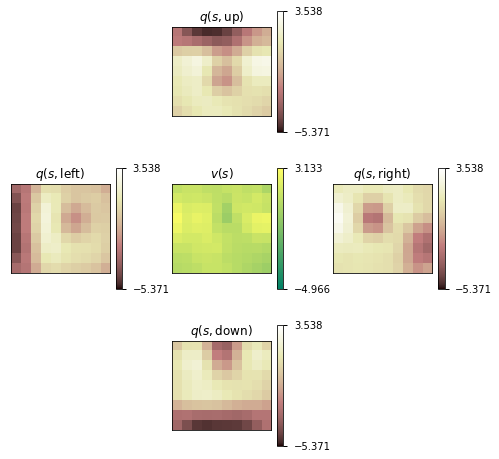

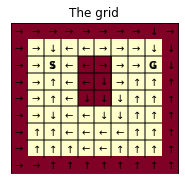

In [125]:
# OnlineQ
grid = FeatureGrid()

agent = LinearExperienceQ(
  number_of_features=grid.number_of_features, number_of_actions=4,
  number_of_states=grid._layout.size, initial_state=grid.get_obs(),
  num_offline_updates=0, step_size=0.01, behaviour_policy=random_policy)
run_experiment(grid, agent, int(1e5))
q = np.reshape(
    np.array([agent.q(grid.int_to_features(i))
              for i in range(grid.number_of_states)]),
    [grid._layout.shape[0], grid._layout.shape[1], 4])
plot_action_values(q)
plot_greedy_policy(grid, q)

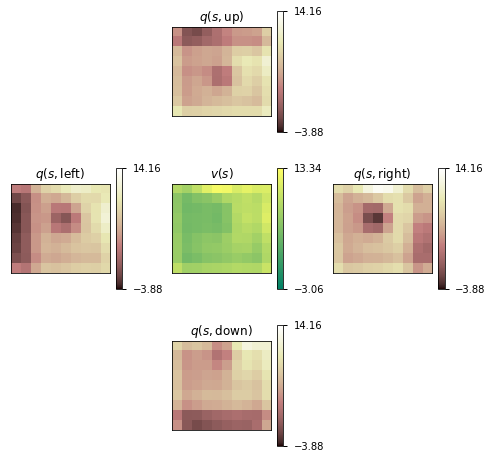

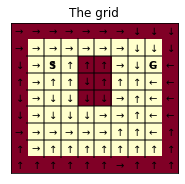

In [126]:
# Experience Replay
grid = FeatureGrid()

agent = LinearExperienceQ(
  number_of_features=grid.number_of_features, number_of_actions=4,
  number_of_states=grid._layout.size, initial_state=grid.get_obs(),
  num_offline_updates=10, step_size=0.01, behaviour_policy=random_policy)
run_experiment(grid, agent, int(1e5))
q = np.reshape(
    np.array([agent.q(grid.int_to_features(i))
              for i in range(grid.number_of_states)]),
    [grid._layout.shape[0], grid._layout.shape[1], 4])
plot_action_values(q)
plot_greedy_policy(grid, q)

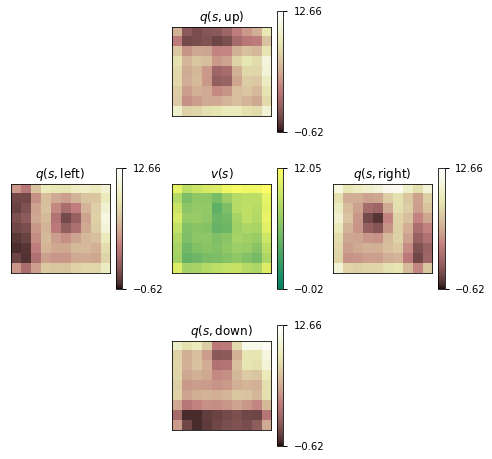

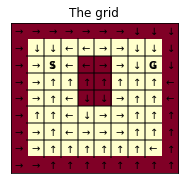

In [82]:
# LinearDynaQ
grid = FeatureGrid()

agent = LinearDynaQ(
  number_of_features=grid.number_of_features, 
  number_of_actions=4,
  number_of_states=grid._layout.size, 
  initial_state=grid.get_obs(),
  num_offline_updates=10, 
  step_size=0.01,
  behaviour_policy=random_policy)

run_experiment(grid, agent, int(1e5))
q = np.reshape(
    np.array([agent.q(grid.int_to_features(i))
              for i in range(grid.number_of_states)]),
    [grid._layout.shape[0], grid._layout.shape[1], 4])
plot_action_values(q)
plot_greedy_policy(grid, q)

### Q 1.3.3 [3 marks]

How do the value estimates learnt with function approximation differ from those learnt in the tabular setting, as in the experiment above question 1.3.2?

Explain the results in at most 5 sentences.


> The value estimates appear more noisy in comparison to the tabular estimates, and thus do no end up having a very clear distinction between the walls, but rather a continuous gradient away from them. Additionally, the value estimates do not appear to display a gradient towards the final goal. Overall, the value estimates learnt with function approximation are less accurate for all three models. Linear approximations are not guaranteed to converge to the optimum because they are limited in their ability to represent Q-values through a linear constraint, while the tabular version is not constrained by this and is able to represent any given Q-value through a direct state-action pair mapping to value. The linear approximation depends on the state features, which there are likely to be less of than the number of states; this results in generalization across states rather than one-to-one mappings and thus updating weights will influence multiple state-action pairs rather than a single one, leading to a continuous representation of values that is less accurate than the discrete tabular model. Additionally, the goal, being only one state, may not have sufficient influence on the weights and associated features such that the mapping does not particularly bias the value estimates towards it, explaining the lapse of a significant gradient towards the goal region. This also explains why instead there are regions of low value estimates near the walls because entire regions (with similar state features) are influencing weights such that the mapping generalizes those areas more.

### Q 1.3.4 [3 marks]

Inspect the policies derived by training agents with linear function approximation on 'FeatureGrid'. 

How do they compare to the optimal policy?

> The policies derived by the linear agents are poor compared to the optimal policy, as there are many seemingly random policies for various states. The optimal policy runs through the top of the gridworld to the shortest path to the goal- none of the linear policies achieve this, with ExperienceReplay being the closest. Because the linear approximation is constrained to a linear mapping from state, action, and value, it cannot accurately represent non-linear relationships/mappings and thus may produce inadequate and inaccurate value estimations, in turn producing suboptimal policies which are dependent on value estimates as they attempt to maximize them. By looking at the value estimates, the corresponding policies are sensible as there is no apparent clearly-defined area of high value or gradient of increasing values toward one, creating a rather uniform value estimation across most states; instead there just appear to be areas of low-values to be avoided. Thus, the policy ultimately yields actions within the 'safe' area that avoids areas of low value estimates, but do not move towards the intended goal in particular. Again, because the linear approximation depends on state features that are smaller than the number of states, there are generalizations across states (explaining the "blur" of regions that likely have similar features). Therefore, the goal, being only one state, may not have sufficient influence on the weights and associated features such that the mapping does not particularly bias the value estimates (and policy) towards it. This also explains why instead there are regions of low value estimates near the walls because entire regions (with similar state features) are influencing weights such that the mapping generalizes those areas more. Thus, with the given value estimates, the policy only learns to avoid walls.

### Run experiments in a non stationary environments

We now consider a non-stationary setting where after `pretrain_steps` in the environment, the goal is moved to a new location (from the top-right of the grid to the bottom-left - refer to "Show gridworlds"). The agent is allowed to continue training for a (shorter) amount of time in this new setting, and then we evaluate the value estimates.

*Online Q-learning*

* $\text{pretrain_steps}$ = $20,000$,  $\text{num_steps}$ = $666$, and $\text{num_offline_updates}$ = $0$

*ExperienceReplay*

* $\text{pretrain_steps}$ = $20,000$,  $\text{num_steps}$ = $666$ and $\text{num_offline_updates}$ = $10$

*DynaQ*

* $\text{pretrain_steps}$ = $20,000$,  $\text{num_steps}$ = $666$ and $\text{num_offline_updates}$ = $10$

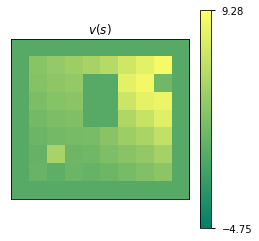

In [140]:
# Online Q

# Train on first environment
pretrain_steps = 2e4
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=0, step_size=0.1)
run_experiment(grid, agent, int(pretrain_steps))
q = agent.q_values.reshape(grid._layout.shape + (4,))

# Change goal location
alt_grid = AltGrid()
run_experiment(alt_grid, agent, int(pretrain_steps / 30))
alt_q = agent.q_values.reshape(alt_grid._layout.shape + (4,))
plot_state_value(alt_q)

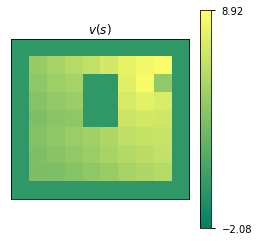

In [129]:
# Experience Replay

# Train on first environment
pretrain_steps = 2e4
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(pretrain_steps))
q = agent.q_values.reshape(grid._layout.shape + (4,))

# Change goal location
alt_grid = AltGrid()
run_experiment(alt_grid, agent, int(pretrain_steps / 30))
alt_q = agent.q_values.reshape(alt_grid._layout.shape + (4,))
plot_state_value(alt_q)

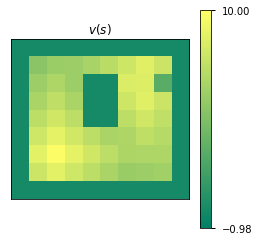

In [136]:
# DynaQ

# Train on first environment
pretrain_steps = 2e4
grid = Grid()
agent = DynaQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(pretrain_steps))
q = agent.q_values.reshape(grid._layout.shape + (4,))

# Change goal location
alt_grid = AltGrid()
run_experiment(alt_grid, agent, int(pretrain_steps / 30))
alt_q = agent.q_values.reshape(alt_grid._layout.shape + (4,))
plot_state_value(alt_q)

### Q 1.3.5 [3 marks]

Compare the value estimates of online Q-learning and Dyna-Q, after training also on the new goal location. 

Explain what you see in at most 5 sentences. 

> Online Q-learning performs worst than Dyna-Q in training on the new goal location because it has 10 times less total updates than Dyna-Q does because it only is performed on-policy and does not have off-policy updates. Thus, Dyna-Q has more updates to converge towards more accurate learned values of the new environment. Dyna-Q still has high value estimates near the previous goal, indicating it has yet to converge as those values have not been sufficiently down-weighted by their new values. If online Q-learning is given the same number of updates as Dyna-Q, it should actually be expected to converge towards new value estimates more rapidly, as it can sample directly from the true environment rather than sampling from a model with values that have yet to be updated (initially). In this sense, Dyna-Q is partially hindered by the fact that it must first encounter new transitions in the environment through the random policy in order to update its model towards the accurate transition values for state-action pairs and will be performing offline updates with incorrect values until those transitions have been encountered.

### Q 1.3.6 [3 marks]

Compare the value estimates of online Experience Replay and Dyna-Q, after training also on the new goal location.

Explain what you see in at most 5 sentences. 

> ExperienceReplay is not very robust to the change in the environment as its value estimates are heavily weighted towards the original goal and not weighted towards the new goal, indicating it has barely learned; the value estimates look approximately the same as they did previously. Alternatively, Dyna-Q is better adapted as it appears to partially downweight value estimates near the previous goal and clearly has placed more weight on values near the new goal. This difference can be explained due to the nature of sampling and offline-updates of the two models. ExperienceReplay performs offline updates using samples directly from its buffer, which still contains transitions from the previous environment states, even after the goal has changed. This makes it difficult for ExperienceReplay to learn because it continues performing offline updates with the wrong transition values, which have well-populated the buffer after 20,000 pretraining steps. As time progresses, more of the new environment transition values are added to the buffer, but (for 666 steps) not enough to significantly alter the bias towards the previous transition values. If ExperienceReplay were to be run for infinitely many steps, it would eventually well-populate the buffer with the new environment samples and have a low probability of sampling an incorrect previous transition from the buffer, and would then learn more efficiently. Alternatively, Dyna-Q is able to adapt to the change in environment more quickly because it samples state-action pairs from a buffer but yields its transition values from a tabular model of the enviornment. Thus, once it encounters a different transition (next_state, reward, discount) for a state-action pair in the enviornment, the model is updated to the new transition and all future samples drawn from the buffer use the new transition in the model- with offline updates, the true transitions can more quickly weight the value estimates in the correct direction after only encountering the new transition once in the environment. This allows Dyna-Q to be more robust to changes in an otherwise deterministic environment. However, as described in 1.3.5, Dyna-Q still performs offline updates with incorrect transition values (like ExperienceReplay) until it encounters the transition in the new environment.


# Part 2: Deep RL [25 marks]

## 2A) Actor-critics

You are going to implement an Actor-critic agent that updates a policy parametrised as a deep neural network.

The agent learns online from a single stream of experience, updating the parametes of its policy after each transition in the environment.

### Install packages

In [31]:
!git clone https://github.com/deepmind/bsuite.git
!pip install bsuite/
!pip install dm-haiku

fatal: destination path 'bsuite' already exists and is not an empty directory.
Processing ./bsuite
  Created wheel for bsuite: filename=bsuite-0.3.5-cp37-none-any.whl size=249666 sha256=e2c7836b3d609bbc7a0b7fab6fffeeb530cbd404d176a6b2a8070f2acb83ef65
  Stored in directory: /private/var/folders/0x/8tc8l1x56_1fkd7s1smrc3jw0000gn/T/pip-ephem-wheel-cache-34iumb76/wheels/fb/40/da/693996a8c432ecba4e0ed1cf477b924423a46ba383655f4a44
Successfully built bsuite
  Found existing installation: bsuite 0.3.5
    Uninstalling bsuite-0.3.5:
      Successfully uninstalled bsuite-0.3.5


### Imports

In [4]:
from bsuite.environments import catch

import jax
import jax.numpy as jnp
import haiku as hk

import numpy as np
import matplotlib.pyplot as plt

### Plotting

In [5]:
def plot_learning_curve(list_of_episode_returns):
  """Plot the learning curve."""
  plt.figure(figsize=(7, 5))

  def moving_average(x, w):
      return np.convolve(x, np.ones(w), 'valid') / w

  smoothed_returns = moving_average(list_of_episode_returns, 30)
  plt.plot(smoothed_returns)

  plt.xlabel('Average episode returns')
  plt.xlabel('Number of episodes')

  ax = plt.gca()
  ax.spines['left'].set_visible(True)
  ax.spines['bottom'].set_visible(True)
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.xaxis.set_ticks_position('bottom')
  ax.yaxis.set_ticks_position('left')

### Neural networks

You will now use JAX to define a network parametrising:

* The values of each state $v_{\pi}(s)$.
* The action preferences in each state $\{p_i(s)\}_{i\in\{1, ..., |A|\}}$ (you can think of and implement the preferences $\mathbf{p}(s)$ as a vector output with $|A|$ elements).

You will use `Haiku` (https://github.com/deepmind/dm-haiku) to define the network. You will need to:
* define the forward pass of the network as some function `fn`
* Use `hk.transform(fn)` to convert this in a pair of functions (`init_net`, and `apply_net`):

The `init` function has signature `parameters = init_net(key, obs)`. 
  * takes a `jax.random.PRNGKey` and an `observation`
  * returns randomly sampled weights for the neural network.

The `apply_net` functions have signature `v, p = apply_net(parameters, key, obs)` 
  * takes the current set of `parameters`, a `jax.random.PRNGKey` and an `observation`
  * returns a scalar value `v` and a vector of preferences `p`

### Q 3.1 [3 marks]

Define the forward pass of the neural network. The network must:

* take an `observation` as input
* reshape the observation into a flat vector `flat_obs`
* compute a hidden representation `h = Relu(W.dot(flat_obs) + b)`
* compute a vector of action preferences as a linear function of `h`
* compute a scalar state value as a linear function of `h`
* return the scalar value and vector preferences.

Note:
* The hidden layer should have 50 units
* the action preferences should be a vector of 3 elements (one per each available action),
* the value should be a scalar (not a vector with one element).


In [6]:
def forward(obs):
    flat_obs = obs.flatten()
    f = hk.Sequential([hk.Linear(50), jax.nn.relu])
    fc1 = hk.Linear(3)
    fc2 = hk.Linear(1)
    h = f(flat_obs)
    p = fc1(h)
    v = fc2(h)    
    return v, p

init_net, apply_net = hk.transform(forward)

### Choosing actions

A critical component of an actor-critic agent is a (stochastic) policy, mapping `observations` to `actions`. 

In deep RL, this mapping is conventionally parametrised by a deep neural network.

### Q 3.2 [2 marks]

Implement a softmax policy parametrised by the neural network above (i.e., using the `apply_net` function).

The function has signature `action = softmax_policy(net_params, key, obs)`,
* Taking the current network parameters `net_params`, a JAX random `key` and the current `observation`
* Returning an `action` sampled from a softmax distribution (with temperature 1.) over the set of preferences output by the neural network.

Functions to perform random sampling in JAX (e.g. those in `jax.random`) take a random key as input, and they are deterministic function of such a key. In general, in a JAX program you will therefore need to use the `split` function to generate a new random key before every new sampling. The run loop that runs the experiment later on splits the key between consecutive calls to the `policy`. Thus you can assume that a new random `key` is provided to you on each call to the `policy`, however if you need a random key in multiple places within the `policy`, do remember to split the key before each use.

In [7]:
@jax.jit
def softmax_policy(net_params, key, obs): 
    """Sample action from a softmax policy."""
    key1, key2 = jax.random.split(key, 2)
    v, p = apply_net(net_params, key1, obs)
    policy = jax.nn.softmax(p)
    action = jax.random.choice(key2, p.shape[0], p = policy)
    return action

### Learning values and policies

An actor-critic agent requires to update the parameters of the network so as to simultaneously improve the value predictions and the policy.

In the next section you will define the gradient updates for each of these two components.

### Q 3.3 [3 marks]

Implement a function to compute a stochastic estimate of the policy gradient from a 1 step transition in the environment.

* You will use $R_{t+1} + \gamma v(S_{t+1})$ as an estimate of $q_{\pi}(S_t, A_t)$
* You will use $v(S_{t})$ as a baseline to reduce the variance of the updates.

The function must have signature `grads = policy_gradient(net_params, obs_tm1, a_tm1, r_t, discount_t, obs_t)`.
* Where the inputs are:
  * the parameters `net_params` of the network,
  * an observation `obs_tm1`
  * the action `a_tm1` selected after observing `obs_tm1`,
  * the resulting reward `r_t` and environment discount `discount_t` 
  * and the following observation `obs_t`
* Returns a stochastic estimate of the policy gradient.
  * `grads` has the same structure as `net_params`
  * as it contains an estimate of the gradient of the expected episodic return wrt to each parameter 

In [8]:
def policy_loss(net_params, key, obs_tm1, a_tm1, r_t, discount_t, obs_t):
    key1, key2 = jax.random.split(key, 2)
    v_tm1, p_tm1 = apply_net(net_params, key1, obs_tm1)
    v_t, p_t = apply_net(net_params, key2, obs_t)
    policy = jax.nn.log_softmax(p_tm1)[a_tm1]
    target = (r_t + discount_t * v_t)[0]
    loss = ((jax.lax.stop_gradient(target) - v_tm1) * policy)[0]
    return loss

def policy_gradient(net_params, key, obs_tm1, a_tm1, r_t, discount_t, obs_t):
    grads = jax.grad(policy_loss)(net_params, key, obs_tm1, a_tm1, r_t, discount_t, obs_t)
    return grads 

### Q 3.4 [3 marks]

Implement a function to compute a stochastic estimate of the negative gradient of the value loss:   $ L(\theta) = E_{s \sim \pi}[(v_{\theta}(s) - v_{\pi}(s))^2]$

As for the policy gradient, this must be computed from a 1 step transition in the environment, so using bootstrapping after one step.

It must have signature `neg_grads = neg_value_loss_gradient(net_params, obs_tm1, a_tm1, r_t, discount_t, obs_t)`.
* Where the inputs are:
  * the current parameters `net_params` of the network,
  * an observation `obs_tm1`
  * the action `a_tm1` selected after observing `obs_tm1`,
  * the resulting reward `r_t` and environment discount `discount_t` 
  * and the following observation `obs_t`
* Returns a stochastic estimate of the policy gradient.
  * `neg_grads` has the same structure as `net_params`
  * as it contains a stochastic estimate of the negative gradient of the expected value prediction loss 

In [35]:
def neg_value_loss(net_params, key, obs_tm1, a_tm1, r_t, discount_t, obs_t):
    key1, key2 = jax.random.split(key, 2)
    v_tm1, p_tm1 = apply_net(net_params, key1, obs_tm1)
    v_t, p_t = apply_net(net_params, key2, obs_t)
    target = (r_t + discount_t*v_t)[0]
    loss = (-(v_tm1 - jax.lax.stop_gradient(target))**2)[0]
    return loss

def neg_value_loss_gradient(net_params, key, obs_tm1, a_tm1, r_t, discount_t, obs_t):
    neg_grads = jax.grad(neg_value_loss)(net_params, key, obs_tm1, a_tm1, r_t, discount_t, obs_t)
    return neg_grads

### Updating shared parameters

The policy gradient identifies the direction of change in the parameters that most steeply improve the policy.
The negative gradient of the value loss identifies the direction of change in the parameters that most steeply improves the value predictions.

However, note that the value and policy share some of the parameters of the network.  How do we combine the two gradient updates?

In this assignment, we will simply sum the policy and value components.
The function that combines the two gradients is implemented for you in the cell below.

In [36]:
@jax.jit
def compute_gradient(net_params, key, obs_tm1, a_tm1, r_t, discount_t, obs_t):
  k1, k2 = jax.random.split(key, 2)
  pgrads = policy_gradient(net_params, k1, obs_tm1, a_tm1, r_t, discount_t, obs_t)
  vgrads = neg_value_loss_gradient(net_params, k2, obs_tm1, a_tm1, r_t, discount_t, obs_t)
  return jax.tree_multimap(lambda pg, vg: pg + vg, pgrads, vgrads)

### Optimisation

The gradient updates are typically rescaled to avoid taking too large a step on a single update.
For instance given a candidate gradient update $\nabla$ we may update our parameters $\theta$ by;
$$\Delta \theta = \theta + \alpha * \nabla\,,$$
where $\alpha$ is a small number between 0 and 1 (e.g., $\alpha=0.01$ or $\alpha=0.001$), referred to as `step_size` or `learning_rate`

The gradients with respect to each weight of a neural network may however have very different magnitudes. This can make it hard to set a suitable learning rate $\alpha$.

In deep learning, and deep RL, we typically use adaptive learning rates, for instance by rescaling each component of the gradient using statistics tracking the typical size of the updates to that weight. Then the entire update is rescaled using a global `learning_rate` $\alpha$


### Q 3.5 [3 marks]

A popular approach to adaptive gradient rescaling was introduced by the `Adam` algorithm.
* See [Kingma et al, 2014](https://arxiv.org/abs/1412.6980) for references.

This algorithm implements the following procedure before applying each update:
* Increase an update counter $k \gets k+1$ (starting at k=0 before any updates),
* Update the first moment of each gradient component $\mu \gets (1 - \beta_1) g + \beta_1 \mu$ where $g$ is the latest stochastic gradient.
* Update the second moment of each gradient component $\nu_i = (1 - \beta_2) g_i ^ 2 + \beta_2 \nu_i $ where $g$ is the latest gradient update.
* Use the following update to update the weights:
$$\Delta w = \alpha \frac{\mu / (1 - \beta_1 ^ {k})}{\epsilon + \sqrt{\nu / (1 - \beta_2 ^ {k})}}$$
* $\alpha$ is a global `learning rate`
* $\beta_1$ and $\beta_2$ define a soft horizon for the per-weight statistics.
* $\epsilon$ makes the rescaling more robust to numerical issues.

In the next cell define a pair of functions (`opt_init`, and `opt_update`), where:

The `opt_init` function has signature `state = opt_init(params)`.
* Takes the network parameters as inputs
* Initialises an `optimiser state` holding the per weight statistics.

The `opt_update` function has signature `updates, state = opt_update(grads, state)`.
* Takes a `gradient` and an `optimisers state`,
* and returns the transformed gradient and the updated `optimiser state`.

Set the algorrithm's hyper-parameters to:
* $\beta_1=.9$ and $\beta_2=.999$, $\epsilon=1e-8$.

In [84]:
# use .01 learning rate for a, .004 for b
def opt_init(params):
    beta_1 = 0.9
    beta_2 = 0.999
    epsilon = 1e-8
    alpha = 0.004
    k = 0
    mu = jax.tree_map(lambda param: jnp.zeros(param.shape), params)
    v = jax.tree_map(lambda param: jnp.zeros(param.shape), params)
    state = {"beta_1": beta_1, "beta_2": beta_2, "epsilon": epsilon, "alpha": alpha, "k": k, "mu": mu, "v": v}
    return state

def opt_update(grads, state):
    state["k"] += 1
    state["mu"] = jax.tree_multimap(lambda mu, g: (1-state["beta_1"])*g + state["beta_1"]*mu, state["mu"], grads)
    state["v"] = jax.tree_multimap(lambda v, g: (1-state["beta_2"])*(g**2) + state["beta_2"]*v, state["v"], grads)
    num = jax.tree_map(lambda mu: mu/(1-state["beta_1"]**state["k"]), state["mu"])
    denom = jax.tree_map(lambda v: v/(1-state["beta_2"]**state["k"]), state["v"])
    grads = jax.tree_multimap(lambda n, d: state["alpha"]*n/(state["epsilon"]+jnp.sqrt(d)), num, denom)
    return grads, state

### Run experiments

Run the cell below to show the performance of the resulting agent.

You may also use this section for debugging your implementations.

Note however, that most functions are `jitted` for performance,
* either using the `@jax.jit` decorator in the function definition
* or calling explicitely `fn = jax.jit(fn)`

When jitting, the code is compiled on the first time the function is executed
* and execution is much faster on subsequent calls.
* a notable side effect is that print statements in a jitted function will only execute on the first execution of the function.
* to drop into a debugger or print on each function execution you will have to disable the `@jax.jit` annotations and jax.jit calls.

Training agent for 1500 episodes...


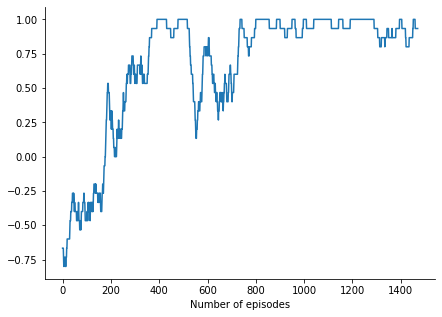

In [44]:
# DO NOT CHANGE THIS CELL

# Experiment configs.
train_episodes = 1500
discount_factor = .99

# Create environment.
env = catch.Catch(seed=42)

# Build and initialize network.
rng = jax.random.PRNGKey(44)
rng, init_rng = jax.random.split(rng)
sample_input = env.observation_spec().generate_value()
net_params = init_net(init_rng, sample_input)

# Initialize optimizer state.
opt_state = opt_init(net_params)

# Apply updates
def apply_updates(params, updates):
  return jax.tree_multimap(lambda p, u: p + u, params, updates)

# Jit.
opt_update = jax.jit(opt_update)
apply_updates = jax.jit(apply_updates)

print(f"Training agent for {train_episodes} episodes...")
all_episode_returns = []

for _ in range(train_episodes):
  episode_return = 0.
  timestep = env.reset()
  obs_tm1 = timestep.observation

  # Sample initial action.
  rng, policy_rng = jax.random.split(rng)
  a_tm1 = softmax_policy(net_params, policy_rng, obs_tm1)

  while not timestep.last():
    # Step environment.
    new_timestep = env.step(int(a_tm1))

    # Sample action from agent policy.
    rng, policy_rng = jax.random.split(rng)
    a_t = softmax_policy(net_params, policy_rng, new_timestep.observation)

    # Update params.
    r_t = new_timestep.reward
    discount_t = discount_factor * new_timestep.discount
    rng, grad_rng = jax.random.split(rng)
    dJ_dtheta = compute_gradient(
        net_params, grad_rng, obs_tm1, a_tm1, r_t, discount_t, 
        new_timestep.observation)
    updates, opt_state = opt_update(dJ_dtheta, opt_state)
    net_params = apply_updates(net_params, updates)

    # Within episode book-keeping.
    episode_return += new_timestep.reward
    timestep = new_timestep
    obs_tm1 = new_timestep.observation
    a_tm1 = a_t

  # Experiment results tracking.
  all_episode_returns.append(episode_return)

# Plot learning curve.
plot_learning_curve(all_episode_returns)

## 2B) An alternative update

You are going to implement a different kind of agent.

Like an actor-critic, it learns online from a single stream of experience, updating the parametes after each transition in the environment.

### Neural networks


The agent will reuse the same neural network we defined for the actor-critic:
* the scalar output will be trained via TD to estimate state values
* the vector preferences `p` will be updated according to a different rule.

### Choosing actions

As in actor-critics, the (stochastic) mapping from `observations` to `actions` depends on the vector of preferences `p` from the network.

### Q 3.6 [3 marks]

The new agent's policy will have the signature `action = epsilon_greedy_policy(net_params, key, obs)`,
* Take as inputs the current network parameters `net_params`, a JAX random `key` and the current `observation`
* Return with probability `0.9` the greedy `action` with respect to the preferences `p`, ties must be broken at random.
* Return an action uniformly at random with probability `0.1`

In [85]:
@jax.jit 
def epsilon_greedy_policy(net_params, key, obs):
    """Sample action from an epsilon-greedy policy.""" 
    key1, key2, key3 = jax.random.split(key, 3)
    v, p = apply_net(net_params, key, obs)
    max_p = jnp.where(p == jnp.max(p), jnp.array(range(len(p))), 0)
    probs = (p == jnp.max(p))/jnp.sum(max_p) * jnp.ones(len(max_p))
    greedy = jax.random.choice(key1, max_p, p = probs)
    random = jax.random.randint(key2, (1,), 0, len(p))
    actions = jnp.array([greedy, random[0]])
    eps = jnp.array([0.9, 0.1])
    action = jax.random.choice(key3, actions, p = eps)
    return action

### Q 3.7 [4 marks]

The preferences `p` will be update according to the following gradient-based update:

* -($R_{t+1} + \gamma v(S_{t+1}) - p(S_{t}, A_t)) \nabla p(S_t, A_t))$ 
* where `v` is the state value trained by TD as in the actor critic.
* note the `-` in front of the update above.

You musy implement this in the function `preference_gradient`, with the same signature as `policy_gradient`

In [86]:
def preference_loss(net_params, key, obs_tm1, a_tm1, r_t, discount_t, obs_t):
    key1, key2 = jax.random.split(key, 2)
    v_tm1, p_tm1 = apply_net(net_params, key1, obs_tm1)
    v_t, p_t = apply_net(net_params, key2, obs_t)
    policy = p_tm1[a_tm1] 
    target = (r_t + discount_t * v_t)[0]
    loss = (-0.5 * (jax.lax.stop_gradient(target) - policy)**2) 
    return loss
    
def preference_gradient(net_params, key, obs_tm1, a_tm1, r_t, discount_t, obs_t):
    grads = jax.grad(preference_loss)(net_params, key, obs_tm1, a_tm1, r_t, discount_t, obs_t)
    return grads

### Updating shared parameters

Just like in the actor critic the overall update to the parameters is a combination of two quantities:
* the new update we defined for the vector of preferences
* the same TD update to the scalar output that we used in the actor critic

In [87]:
@jax.jit
def compute_gradient(net_params, key, obs_tm1, a_tm1, r_t, discount_t, obs_t):
  k1, k2 = jax.random.split(key, 2)
  pgrads = preference_gradient(net_params, k1, obs_tm1, a_tm1, r_t, discount_t, obs_t)
  vgrads = neg_value_loss_gradient(net_params, k2, obs_tm1, a_tm1, r_t, discount_t, obs_t)
  return jax.tree_multimap(lambda pg, vg: pg + vg, pgrads, vgrads)

### Optimisation

The gradient updates are rescaled using the same optimiser used for the actor-critic.

### Run experiments

Run the cell below to show the performance of the new agent.

Training agent for 1500 episodes...


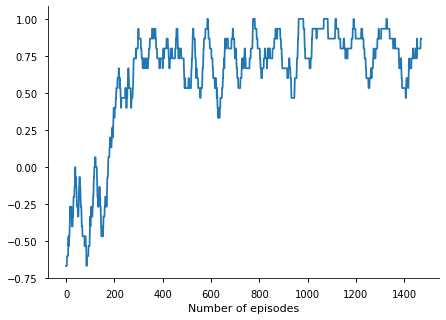

In [88]:
# DO NOT CHANGE THIS CELL

# Experiment configs.
train_episodes = 1500
discount_factor = .99

# Create environment.
env = catch.Catch(seed=42)

# Build and initialize network.
rng = jax.random.PRNGKey(44)
rng, init_rng = jax.random.split(rng)
sample_input = env.observation_spec().generate_value()
net_params = init_net(init_rng, sample_input)

# Initialize optimizer state.
opt_state = opt_init(net_params)

# Apply updates
def apply_updates(params, updates):
  return jax.tree_multimap(lambda p, u: p + u, params, updates)

# Jit.
opt_update = jax.jit(opt_update)
apply_updates = jax.jit(apply_updates)

print(f"Training agent for {train_episodes} episodes...")
all_episode_returns = []

for _ in range(train_episodes):
  episode_return = 0.
  timestep = env.reset()
  obs_tm1 = timestep.observation

  # Sample initial action.
  rng, policy_rng = jax.random.split(rng)
  a_tm1 = epsilon_greedy_policy(net_params, policy_rng, obs_tm1)

  while not timestep.last():
    # Step environment.
    new_timestep = env.step(int(a_tm1))

    # Sample action from agent policy.
    rng, policy_rng = jax.random.split(rng)
    a_t = epsilon_greedy_policy(net_params, policy_rng, new_timestep.observation)

    # Update params.
    r_t = new_timestep.reward
    discount_t = discount_factor * new_timestep.discount
    rng, grad_rng = jax.random.split(rng)
    dJ_dtheta = compute_gradient(
        net_params, grad_rng, obs_tm1, a_tm1, r_t, discount_t, 
        new_timestep.observation)
    updates, opt_state = opt_update(dJ_dtheta, opt_state)
    net_params = apply_updates(net_params, updates)

    # Within episode book-keeping.
    episode_return += new_timestep.reward
    timestep = new_timestep
    obs_tm1 = new_timestep.observation
    a_tm1 = a_t

  # Experiment results tracking.
  all_episode_returns.append(episode_return)

# Plot learning curve.
plot_learning_curve(all_episode_returns)

### Q 3.8 [4 marks]

[1pts]: What is the best asymptotic average return that can be achieved by the actor-critic agent described in `Part 2A)`?

> The best asymptotic average return that can be achieved by the actor-critic in 2A is 1.

[1pts] What is the best asymptotic average return that can be achieved by the second agent described in `Part 2B)`?

> The best asymptotic average return that can be achieved by the actor-critic in 2B is 1.

[2pts] What quantity do the preferences `p` estimate in the second agent described in `Part 2B)`?

> The preferences `p` estimate $Q_\mu(s_t,a_t)$: the action-values under the behavior policy. They are updated towards the target action-values that they are trying to parameterize for. 

# Part 3: Off-policy multi-step learning [40 marks]

### Q4 [15 marks]
For many concrete algorithms, we need to combine multi-step updates with off-policy corrections.  The multi-step updates are necessary for efficient learning, while the off-policy corrections are necessary to learn about multiple things at once, or to correct for a distribution mismatch (e.g., when trying to perform a policy-gradient update from logged data).

In this section, you will implement various different returns with off-policy corrections.  The next cell has two examples *without* corrections.  These examples compute equivalent returns, but compute those returns in different ways.  These are provided as reference implementations to help you.

Note that the implementations both allow for immediate bootstrapping on the current state value. This is unconventional (most literature only allows the first bootstrapping to happen after the first step), but we will use this convention in all implementations below for consistency. 

In [71]:
#@title On-policy return computations

def on_policy(observations, actions, pi, mu, rewards, discounts,
              trace_parameter, v_fn):
  """Compute on-policy return recursively."""
  del mu  # The policy probabilities are ignored by this function
  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  G = np.zeros((T,))
  # recurse backwards to calculate returns
  for t in reversed(range(T)):
    # There are T+1 observations, but only T rewards, and the indexing here
    # for the rewards is off by one compared to the indexing in the slides
    # and in Sutton & Barto.  In other words, r[t] == R_{t+1}.
    if t == T - 1:
      G[t] = r[t] + d[t]*v[t + 1]
    else:
      G[t] = r[t] + d[t]*((1 - l)*v[t + 1] + l*G[t + 1])
  v = v[:-1]  # Remove (T+1)th observation before calculating the returns
  return (1 - l)*v + l*G

def on_policy_error_recursion(observations, actions, pi, mu, rewards, discounts,
                              trace_parameter, v_fn):
  del pi  # The target policy probabilities are ignored by this function
  del mu  # The behaviour policy probabilities are ignored by this function
  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  errors = np.zeros((T,))
  error = 0.
  # recurse backwards to calculate errors
  for t in reversed(range(T)):
    error = r[t] + d[t]*v[t + 1] - v[t] + d[t]*l*error
    errors[t] = error
  v = v[:-1]  # Remove (T+1)th observation before calculating the returns
  return v + l*errors

### Q 4.1 [7 marks]
Implement the return functions below and run the cells below that.

In [78]:
def full_importance_sampling(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
    """
      Compute off-policy return with full importance-sampling corrections, so that
      the return G_t is corrected with the full importance-sampling correction of
      the rest of the trajectory.
      """
    T = len(rewards)  
    a = actions
    G = on_policy(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn)
    G_hat = np.zeros((T,))
    l = trace_parameter
    v = np.array([v_fn(o) for o in observations])
    rho = 1 
    for t in reversed(range(T)):
        rho = rho*(pi[t]/mu[t])
        G_hat[t] = rho*G[t]
    v = v[:-1] 
    return (1 - l)*v + l*G_hat      

def per_decision(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
    """
    Compute off-policy return with per-decision importance-sampling corrections.
    """
    T = len(rewards)  
    a = actions
    r = rewards
    d = discounts
    l = trace_parameter
    G_rho = np.zeros((T,))
    v = np.array([v_fn(o) for o in observations])
    for t in reversed(range(T)):
        rho = pi[t]/mu[t]
        if t == T-1:
            G_rho[t] = rho*(r[t] + d[t]*v[t+1])
        else:
            G_rho[t] = rho*(r[t] + d[t]*((1-l)*v[t+1] + l*G_rho[t+1]))   
    v = v[:-1]  
    return (1 - l)*v + l*G_rho
    
def control_variates(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
    """
    Compute off-policy return with 
    1. per-decision importance-sampling corrections, and
    2. control variates
    """
    T = len(rewards) 
    a = actions
    r = rewards
    d = discounts
    l = trace_parameter
    v = np.array([v_fn(o) for o in observations])
    G_delta = np.zeros((T,))
    for t in reversed(range(T)):
        rho = pi[t]/mu[t]
        delta = r[t] + d[t]*v[t+1] - v[t]
        if t == T-1:
            G_delta[t] = rho*delta + v[t]
        else:
            G_delta[t] = rho*(delta + d[t]*l*(G_delta[t+1] - v[t+1])) + v[t]    
    v = v[:-1]  
    return (1 - l)*v + l*G_delta
    
def adaptive_bootstrapping(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
    """
    Compute off-policy return with 
    1. per-decision importance-sampling corrections, and
    2. control variates, and
    3. adaptive bootstrapping.

    Implement the adaptive bootstrapping with an *additional* trace parameter
    lambda, such that lambda_t = lambda * min(1, 1/rho_t).
    """
    
    T = len(rewards)  
    a = actions
    r = rewards
    d = discounts
    l = trace_parameter
    v = np.array([v_fn(o) for o in observations])
    G_delta = np.zeros((T,))
    for t in reversed(range(T)):
        rho = pi[t]/mu[t]
        l_t = min(1, 1/rho)
        delta = r[t] + d[t]*v[t+1] - v[t]
        if t == T-1:
            G_delta[t] = l_t*rho*delta + v[t]
        else:
            G_delta[t] = l_t*rho*(delta + d[t]*(G_delta[t+1] - v[t+1])) + v[t]    
    v = v[:-1]  
    return (1 - l)*v + l*G_delta

In [79]:
#@title (Run, don't modify) Functions to generate experience, compute values
MU_RIGHT = 0.5
PI_RIGHT = 0.9
NUMBER_OF_STEPS = 5
DISCOUNT = 0.99

def generate_experience():
  r"""Generate experience trajectories from a tabular tree MDP.

  This function will start in state 0, and will then generate actions according
  to a uniformly random behaviour policy.  When A_t == 0, the action will be to
  the left, with A_t==1, it will be to the right.  The states are nunmbered as
  depicted below:
          0
         / \
        1   2
       / \ / \
      3   4   5
         ...
  
  Args:
      number_of_steps: the number of total steps.
      p_right: probability of the behaviour to go right.

  Returns:
      A dictionary with elements:
        * observations (number_of_steps + 1 integers): the
          observations are just the actual (integer) states
        * actions (number_of_steps integers): actions per step
        * rewards (number_of_steps scalars): rewards per step
        * discounts (number_of_steps scalars): currently always 0.9,
          except the last one which is zero
        * mu (number_of_steps scalars): probability of selecting each
          action according to the behavious policy
        * pi (number_of_steps scalars): probability of selecting each
          action according to the target policy (here p(1) = 0.9 and
          p(0) = 0.1, where a==1 implies we go 'right')
  """
  # generate actions
  actions = np.array(np.random.random(NUMBER_OF_STEPS,) < MU_RIGHT,
                     dtype=np.int)
  s = 0
  # compute resulting states
  states = np.cumsum(np.arange(1, NUMBER_OF_STEPS + 1) + actions)
  states = np.array([0] + list(states))  # add start state
  # in this case, observations are just the real states
  observations = states
  # generate rewards
  rewards = 2.*actions - 1. # -1 for left, +1 for right, 
  rewards[-1] = np.sum(actions)  # extra final reward for going right
  # compute discounts
  discounts = DISCOUNT * np.ones_like(rewards)
  discounts[-1] = 0.  # final transition is terminal, has discount=0
  # determine target and behaviour probabilities for the selected actions
  pi = np.array([1. - PI_RIGHT, PI_RIGHT])[actions] # Target probabilities
  mu = np.array([1. - MU_RIGHT, MU_RIGHT])[actions] # Behaviour probabilities
  return dict(observations=observations,
              actions=actions,
              pi=pi,
              mu=mu,
              rewards=rewards,
              discounts=discounts)

def true_v(s, pi, number_of_steps):
  """Compute true state value recursively."""
  depth = int(np.floor((np.sqrt(1 + 8*s) - 1)/2))
  position = int(s - depth*(depth+1)/2)
  remaining_steps = number_of_steps - depth
  final_reward = DISCOUNT**(remaining_steps-1)*(position + pi*remaining_steps)
  reward_per_step = pi*(+1) + (1 - pi)*(-1)
  discounted_steps = (1 - DISCOUNT**(remaining_steps - 1))/(1 - DISCOUNT)
  reward_along_the_way = reward_per_step * discounted_steps
  return reward_along_the_way + final_reward



/Users/Administrator/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


[ 18.793 526.781 171.636   6.054   0.807]


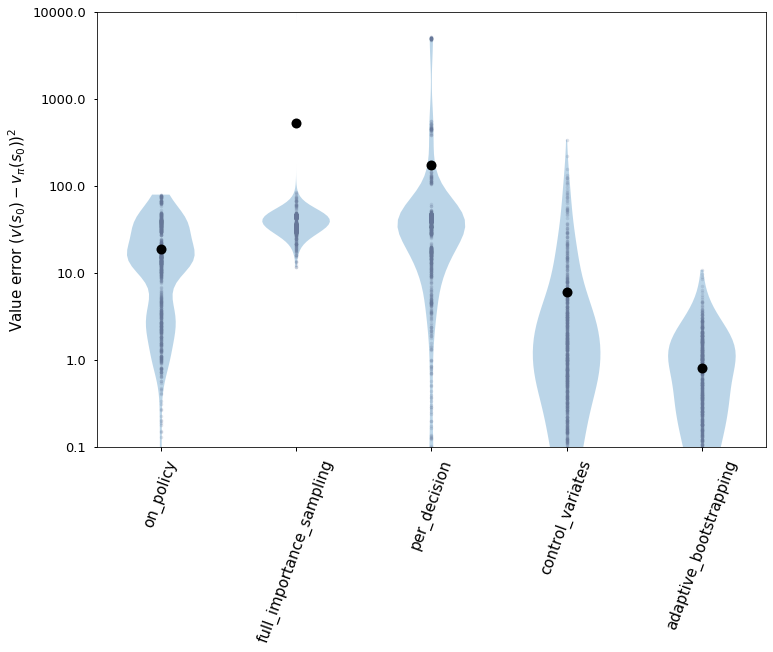

In [80]:
#@title Run experiment (don't modify)
algs = ['on_policy', 'full_importance_sampling', 'per_decision',
        'control_variates', 'adaptive_bootstrapping']

# Precompute state values (for efficiency)
N = NUMBER_OF_STEPS
true_vs = [true_v(s, PI_RIGHT, N) for s in range((N+1)*(N+2)//2)]

def random_v(iteration, s):
  rng = np.random.RandomState(seed=s + iteration*10000)
  return true_vs[s] + rng.normal(loc=0, scale=1.)  # Add fixed random noise 

def plot_errors(ax, errors):
  errors = np.array(errors)
  ax.violinplot(np.log10(errors), showextrema=False)
  ax.plot(range(1, len(algs)+1), np.log10(errors).T,
          '.', color='#667799', ms=7, alpha=0.2)
  ax.plot(range(1, len(algs)+1), np.log10(np.mean(errors, axis=0)),
          '.', color='#000000', ms=20)
  ax.set_yticks(np.arange(-2, 5))
  ax.set_yticklabels(10.**np.arange(-2, 5), fontsize=13)
  ax.set_ylabel("Value error $(v(s_0) - v_{\\pi}(s_0))^2$", fontsize=15)
  ax.set_xticks(range(1, len(algs)+1))
  ax.set_xticklabels(algs, fontsize=15, rotation=70)
  ax.set_ylim(-1, 4)

fig = plt.figure(figsize=(12, 8))

errors = []
estimates = []
v0 = true_vs[0]
for iteration in range(1000):
  errors.append([])
  estimates.append([])
  trajectory = generate_experience()
  for alg in algs:
    estimate = eval(alg)(**trajectory,
                        v_fn=lambda s: random_v(iteration, s),
                        trace_parameter=0.9)
    errors[-1].append((estimate[0] - v0)**2)
print(np.mean(errors, axis=0))
plot_errors(plt.gca(), errors)

Above, the distributions of mean squared value errors are shown, with the mean as a big black dot and the (1,000) individual return samples as small black dots.

### Q 4.2 [4 marks]
Explain the ranking in terms of value error of the different return estimates.

> Importance sampling performs the worst out of the off-policy multi-step return estimates. This occures because the importance weight is recursively multiplied to the return, such that at time-step $t$, $\hat{G}_t=\frac{\pi(A_t|S_t)}{\mu(A_t|S_t)}\dots \frac{\pi(A_T|S_T)}{\mu(A_T|S_T)}G_t$. This introduces variance for every importance-weight introduced, yielding high variance for the corrected return. Thus it yields the worst performance. <br/> <br/>
Alternatively, the per-decision importance-sampling correction yields slightly better performance, with a lower mean value error. Per-decision importance weighting acts to reduce variance by only using importance weighting $\rho_t$ instead of $\rho_{t:T-1}$, since earlier rewards do not depend on later actions. Thus, it performs better than importance sampling. <br/> <br/>
Control variates performs next best as it still uses per-decision importance-sampling to reduce variance and additionally introduces control variates, which effectively weight errors, additionally reducing variance- it uses $(1-\frac{\pi(A_t|S_t)}{\mu(A_t|S_t)})v_t$, which varies with the return but has an expected value of 0. <br/> <br/>
Finally, adaptive bootstrapping performs best as it adds to per-decision and control variates, a control variate that adapts based on the value of the importance sample. This allows the model to bootstrap only as much as it goes off-policy, further minimizing variance, while still avoiding the deadly triad. Thus, when $\frac{\mu(A_t|S_t)}{\pi(A_t|S_t)} > 1$, the sum of errors is truncated to 1. 

### Q 4.3 [4 marks]
Could there be a reason to **not** choose the best return according to this ranking when learning off-policy?  Explain your answer.

> Yes, there could be a reason to not choose the best return according to this ranking when learning off-policy. 
This would correspond to adaptive bootstrapping: since we are also performing off-policy learning, if we use function approximation, this method may diverge due to the presence of the deadly triad (off-policy, bootstrapping, function approximation) if we end up bootstrapping too much. Additionally, in the case that the target policy $\pi$ is computationally intractable, all of the above methods will suffer and thus other methods without importance sampling methods may fare better.


### Q5 [25 marks]
 Consider a MDP $M = (\mathcal{S}, \mathcal{A}, p, r, \gamma)$ and a behaviour policy $\mu$. We use policy $\mu$ to generate trajectories of experience:
\begin{equation*}
    (s_{t}, a_{t}, r_{t},s_{t+1}, a_{t+1}, r_{t+1},\cdots, s_{t+n-1}, a_{t+n-1}, r_{t+n-1}, s_{t+n}, a_{t+n}) \,.
\end{equation*}
Note that this is an $n$-step sequence, starting from time $t$.

Given these partial trajectories we consider the following learning problems:

### Q5.1 [10 marks]
Consider a learning update based on the following temporal difference error:
    \begin{equation}
        \delta_t = r(s_{t},a_{t}) + \gamma  r(s_{t+1},a_{t+1}) + \gamma^2 \max_{a} q(s_{t+2},a) - q(s_t, a)
    \end{equation}

Consider updating a tabular action value function with TD. 
* i) Does the resulting value function converge, under any initialisation of the value function? Consider an appropiate learning rate (Robbins–Monro conditions). If so, prove the convergence under infinity number of interactions with this MDP, under behaviour policy $\mu$ and show its convergence point. If not, show why it diverges. (7 marks)
* ii) Under which conditions, would the above process converge to the optimal value function $q_*$? (3 marks)

### Q5.2 [15 marks]

Consider the same questions now for the following temporal difference error
\begin{equation}
        \delta_t = r(s_{t},a_{t}) + \gamma \frac{\pi(a_{t+1}|s_{t+1})}{\mu(a_{t+1}|s_{t+1})} \left[ r(s_{t+1},a_{t+1}) + \gamma^2 \max_{a} q(s_{t+2},a) \right] - q(s_t, a_t)
\end{equation}

where $\pi(a|s) \in \arg\max_a q(s,a), \forall s,a \in \mathcal{A} \times \mathcal{S}$ and consider the behaviour policy to be: a) $\mu(a|s) \in \arg\max_a q(s,a), \forall s,a \in \mathcal{A} \times \mathcal{S}$, b) $\mu(a|s) = \frac{1}{|\mathcal{A}|}$ (uniformly random policy).

Answer the below two questions for **both choices** of the behaviour policy $\mu$:
* i)  Does updating a tabular action value function with this TD error converge to the optimal value function $q_*$? Consider an appropiate learning rate (Robbins–Monro conditions). If so, prove this convergence under infinity number of interaction with this MDP, under behaviour policy $\mu$. If not, show why it diverges or alternatively convergence to a different solution. (6 marks)
* ii) How does the variance of this update compare to the one induced by the error in Q5.1? (5 marks). 
* iii) Can you propose a different behaviour policy that achieves a lower variance than any of the choices we considered for $\mu$? Prove that your behaviour policy achieve this. Argue why, if that is not possible. (4 marks)

### Q5.1 Answer
i)

##### Theorem:
A random iterative process $\Delta_{t+1}=(1-\alpha_t)\Delta_t + \beta_tF_t$ converges to 0 under the following assumptions: <br/>
1. The state space is finite <br/>
2. The Robbins-Monro conditions hold: $\sum\limits^ \infty \alpha = \infty$; $\sum\limits^\infty \alpha^2 < \infty$; $\sum\limits^\infty \beta = \infty$; $\sum\limits^\infty \beta^2 < \infty$; $E[\beta] \leq E[\alpha]$. <br/>
3. $\|E[F_t]\| \leq \gamma \|\Delta_t \|$ <br/>
4. $var(F_t) \leq C(1+\|\Delta_t\|)^2$ for a constant C <br/>
(from https://dspace.mit.edu/bitstream/handle/1721.1/7205/AIM-1441.pdf?sequence=2 ) <br/> <br/>

The temporal difference update can be written <br/>
$q_{t+1}(s_{t+1},a_{t+1}) = q_t(s_t, a_t) + \alpha_t\delta_t$ <br/>
$= q_t(s_t, a_t) + \alpha_t(r_{t+1}(s_t,a_t) + \gamma r_{t+2}(s_{t+1},a_{t+1}) + \gamma^2\max_a q_{t+2}(s_{t+2},a_{t+2})-q_t(s_t,a_t))$ <br/> <br/>

Let the estimated return be defined as
$G_t = r_{t+1}(s_t,a_t)+\gamma r_{t+2}(s_{t+1}, a_{t+1}) + \gamma^2 \max_a q_{t+2}(s_{t+2},a_{t+2})$ <br/> 
Then <br/>
$q_{t+1}(s_{t+1},a_{t+1}) = q_t(s_t,a_t) + \alpha_t(G_t-q_t(s_t,a_t))$ <br/>
$ = (1-\alpha_t)q_t(s_t,a_t) + \alpha_t G_t$ <br/>

To compute the action value update, the optimal value function is subtracted <br/> 
$q_{t+1}(s_{t+1},a_{t+1})-q_\pi(s_t,a_t)=(1-\alpha_t)q_t(s_t,a_t) + \alpha_t G_t - q_\pi(s_t,a_t)$ <br/>
$=(1-\alpha_t)q_t(s_t,a_t) + \alpha_t G_t +\alpha q_\pi(s_t,a_t) - \alpha q_\pi(s_t,a_t) - q_\pi(s_t,a_t)$ <br/>
$=(1-\alpha_t)q_t(s_t,a_t) + \alpha_t G_t - (1-\alpha) q_\pi(s_t,a_t) - \alpha q_\pi(s_t,a_t)$ <br/>
$=(1-\alpha_t)(q_t(s_t,a_t)-q_\pi(s_t,a_t)) + \alpha_t(G_t - q_\pi(s_t,a_t))$ <br/> <br/>

Let $\Delta_n = q_n(s_n,a_n)-q_\pi(s_n,a_n)$. Then, <br/>
$\Delta_{t+1}=(1-\alpha_t)\Delta_t + \alpha_t(G_t-q_\pi(s_t,a_t))$ <br/>
This yields the exact functional form in the theorem, with $\beta_t = \alpha_t$ and $F_t = G_t-q_\pi(s_t,a_t)$. Thus, to prove that convergence occurs, the 4 assumptions in the above theorem must be shown to be true. <br/> <br/>

Because the MDP is updating a tabular action value function, it is finite and the state space is finite. Thus, assumption 1 is satisfied. <br/> <br/>

As defined, $\alpha_t = \beta_t$. Thus, $E[\beta_t]\leq E[\alpha_t]$. Furthermore, in this model we consider an appropriate learning rate (Robbins-Monro conditions), which is specifically defined as $\sum\limits^ \infty \alpha = \infty$; $\sum\limits^\infty \alpha^2 < \infty$. Because $\alpha_t, \beta_t$ are functions of $s_t, a_t$, in order for the condition to hold, the behavior policy must ensure that all state-action pairs are encountered infinitely many times, as per Greedy in the Limit with Infinite Exploration.  In this case, assumption 2 is satisfied. <br/> <br/>

$E[G_t]=E[r_{t+1}(s_t,a_t)+\gamma r_{t+2}(s_{t+1},a_{t+1}) + \gamma ^2 \max_a q_{t+2}(s_{t+2},a_{t+2})]$ <br/>
The Bellman operator is defined as $T^*(q_t(s_t,a_t)) = E[r_{t+1}+\gamma \max_{a} q_{t+1}(s_{t+1},a_{t+1})]$. Thus, <br/>
$=E[r_{t+1}(s_t,a_t)+\gamma T^*(q_{t+1}(s_{t+1},a_{t+1}))]$ <br/>
$=T^*(q_t(s_t,a_t))$ <br/>
The Bellman operator has one unique fixed point such that <br/>
$T^*(q_\pi(s_t,a_t)) = q_\pi(s_t,a_t)$ <br/>
Then, <br/>
$E[G_t-q_\pi(s_t,a_t)]=T^*(q_t(s_t,a_t))-T^*(q_\pi(s_t,a_t))$ <br/> 
Bellman Operators additionally have the property that they are a contraction with respect to $\|\cdot\|_\infty$. Thus, <br/>
$\|T^*(q_t(s_t,a_t))-T^*(q_\pi(s_t,a_t))\|_\infty \leq \gamma\|q_t(s_t,a_t)-q_\pi(s_t,a_t)\|_\infty$. <br/>
This exactly matches the form of assumption 3: <br/>
$\|E[F_t]\| < \gamma \|\Delta_t\|$ <br/>
Thus, assumption 3 holds. <br/> <br/>

$var[F_t] = E[(r_{t+1}(s_t,a_t)+\gamma T^*(q_{t+1}(s_{t+1},a_{t+1})-q_\pi(s_t,a_t)-E[F_t])^2]$ <br/>
$=E[(r_{t+1}(s_t,a_t)+\gamma T^*(q_{t+1}(s_{t+1},a_{t+1}))-q_\pi(s_t,a_t)-T^*(q_t(s_t,a_t))+T^*(q_\pi(s_t,a_t)))^2]$ <br/>
$=E[(r_{t+1}(s_t,a_t)+\gamma T^*(q_{t+1}(s_{t+1},a_{t+1}))-T^*(q_t(s_t,a_t)))^2]$ <br/>
$=var(r_{t+1}(s_t,a_t)+\gamma T^*(q_{t+1}(s_{t+1},a_{t+1}))-T^*(q_t(s_t,a_t)))$ <br/>
Because r is bounded, 
$\leq C(1+\|q_t(s_t,a_t)-q_\pi(s_t,a_t)\|^2)=C(1+\|\Delta_t\|)^2$ for some constant $C$. Thus, assumption 4 holds and we prove that the MPD converges as $t\rightarrow \infty$ with a GLIE behavior policy. 

ii)
The above process converges to the optimal value function $q^*$ if the behavior policy is greedy in the limit with infinite exploration (GLIE), so as for the MDP to have explored each state sufficiently (infinitely many times), before converging to the greedy optimum. Additionally, the Robbins-Monro conditions must be satisfied.

### Q5.2 Answer

i)

Similarly to (5.1), <br/>
$E[v_t] = E[r_{t+1}(s_t,a_t)+\gamma \frac{\pi(a_{t+1}|s_{t+1})}{\mu(a_{t+1}|s_{t+1})}[r_{t+2}(s_{t+1},a_{t+1})+\gamma \max_a q_{t+2}(s_{t+2},a)]]$ <br/>
$=\sum\limits_{s_{t+1},r_{t+1}} p(s_{t+1},r_{t+1}|s_t,a_t)[r_{t+1}(s_{t+1},a_{t+1})+\gamma \sum\limits_{a_{t+1}} \mu(a_{t+1}|s_{t+1}) \frac{\pi(a_{t+1}|s_{t+1})}{\mu(a_{t+1}|s_{t+1})} \sum\limits_{s_{t+2},r_{t+2}} p(s_{t+2},r_{t+2}|s_{t+1},a_{t+1})[r_{t+2}(s_{t+1},a_{t+1})+\gamma \max_a q_{t+2}(s_{t+2},a)]]$ <br/>
$=\sum\limits_{s_{t+1},r_{t+1}} p(s_{t+1},r_{t+1}|s_t,a_t)[r_{t+1}(s_{t+1},a_{t+1})+\gamma \sum\limits_{a_{t+1}} \pi(a_{t+1}|s_{t+1}) \sum\limits_{s_{t+2},r_{t+2}} p(s_{t+2},r_{t+2}|s_{t+1},a_{t+1})[r_{t+2}(s_{t+1},a_{t+1})+\gamma \max_a q_{t+2}(s_{t+2},a)]]$ <br/>
Because $\pi(a|s)\in \arg \max q(s,a)$, 
$=\sum\limits_{s_{t+1},r_{t+1}} p(s_{t+1},r_{t+1}|s_t,a_t)[r_{t+1}(s_{t+1},a_{t+1})+\gamma \max_{a} \sum\limits_{s_{t+2},r_{t+2}} p(s_{t+2},r_{t+2}|s_{t+1},a_{t+1})[r_{t+2}(s_{t+1},a_{t+1})+\gamma \max_a q_{t+2}(s_{t+2},a)]]$ <br/>
$=E[r_{t+1}(s_t,a_t)+\gamma \max_a r_{t+2}(s_t,a) + \gamma^2 \max_a q_{t+2}(s_{t+2},a_{t+2})]$ <br/>
Using the definition of the Bellman operator, <br/>
$=E[r_{t+1}(s_t,a_t)+\gamma T^*(q_{t+1}(s_{t+1},a_{t+1})]$ <br/> 
$=T^*(q_t(s_t,a_t))$ <br/>
Thus, we end up with the same form as in (5.1) and can conclude from the same proof that the MDP converges.

ii) 

The variance of the update in (5.1) is:  <br/>
$E[(\gamma r_{t+2}(s_{t+1},a_{t+1}) + \gamma ^2 \max_a q_{t+2}(s_{t+2},a))^2]$ <br/>
$= \sum\limits_{a} \mu(a_{t+1}|s_{t+1})(\gamma r_{t+2}(s_{t+1},a_{t+1}) + \gamma ^2 \max_a q_{t+2}(s_{t+2},a))^2$ <br/>

The variance of the update in Q5.2 is: <br/>
$E[(\frac{\pi(a_{t+1}|s_{t+1})}{\mu(a_{t+1}|s_{t+1})}(\gamma r_{t+2}(s_{t+1},a_{t+1}) + \gamma ^2 \max_a q_{t+2}(s_{t+2},a)))^2]$ <br/>
$=\sum\limits_{a} \frac{\pi(a_{t+1}|s_{t+1})^2}{\mu(a_{t+1}|s_{t+1})}(\gamma r_{t+2}(s_{t+1},a_{t+1}) + \gamma ^2 \max_a q_{t+2}(s_{t+2},a))^2$ <br/>

For behavior policy (a), $\mu(a_{t+1}|s_{t+1})=\pi(a_{t+1}|s_{t+1})$. Thus, the variance of the update is: <br/>
$\sum\limits_{a} \pi(a_{t+1}|s_{t+1}) (\gamma r_{t+2}(s_{t+1},a_{t+1}) + \gamma ^2 \max_a q_{t+2}(s_{t+2},a))^2$ <br/>
$=\sum\limits_{a} \mu(a_{t+1}|s_{t+1}) (\gamma r_{t+2}(s_{t+1},a_{t+1}) + \gamma ^2 \max_a q_{t+2}(s_{t+2},a))^2$ <br/>
yielding the same variance as the update in Q5.1 for the greedy behavior policy $\mu$. Furthermore, because $\mu(a_{t+1}|s_{t+1})$ is greedy, it yields 1 for the optimal action and 0 for all suboptimal actions, allowing the variance to be rewritten: <br/>
$=(\gamma \max_a r_{t+2}(s_{t+1},a) + \gamma ^2 \max_a q_{t+2}(s_{t+2},a))^2$

For behavior policy (b), $\mu(a_{t+1}|s_{t+1}) = \frac{1}{|\mathcal{A}|}$. Additionally, the target policy is $\pi(a_{t+1}|s_{t+1}) \in \arg \max_a q(s,a)$. Because the target policy is greedy, the variance can be rewritten as: <br/>
$\frac{1}{\mu(a_{t+1}|s_{t+1})} (\gamma \max_a r_{t+2}(s_{t+1},a) + \gamma ^2 \max_a q_{t+2}(s_{t+2},a))^2$ <br/>
$=|\mathcal{A}|(\gamma \max_a r_{t+2}(s_{t+1},a) + \gamma ^2 \max_a q_{t+2}(s_{t+2},a))^2$ <br/>
Because $|\mathcal{A}| \geq 1$, the variance is greater than or equal to that of (5.1, 5.2a): <br/>
$\geq (\gamma \max_a r_{t+2}(s_{t+1},a) + \gamma ^2 \max_a q_{t+2}(s_{t+2},a))^2$ <br/>
Thus, the variance of behavior policy (b) in (5.2) has a variance greater than or equal to (5.1), assuming a greedy behavior policy, and behavior policy (a) in (5.2).

iii)

It is not possible to yield a different behavior policy with lower variance than any of the choices we considered for $\mu$. From the form of the variance in (ii), it can be observed that the only way to decrease the variance through the behavior policy is by increasing $\mu$. When $\mu$ behaves optimally according to behavior policy (a), $\frac{\pi(a_{t+1}|s_{t+1})}{\mu(a_{t+1}|s_{t+1})} = \frac{1}{1} = 1$. Thus, the only way to further decrease the variance would be for $\mu > 1$, which is not possible.